In [1]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import data_manager
import feature_generator
import MT5_connector
import pandas as pd
import importlib
import joblib
import pytz
import config as cfg
import MetaTrader5 as mt5
from datetime import datetime, timedelta

In [3]:
mt5.initialize()

True

In [25]:
importlib.reload(feature_generator)

<module 'feature_generator' from 'G:\\extracted\\ML\\GoldUsd\\trading_bot\\feature_generator.py'>

In [4]:
df = data_manager.get_mt5_rates("XAUUSD.ecn", mt5.TIMEFRAME_M5, "time_range",from_time=datetime(2025,7,9), to_time=datetime(2025,9,15))
features = feature_generator.MT5FeaturesManager(df)
feature = features.add_all_features()
clean = features.handle_missing_values('drop')
len(clean)

XAUUSD.ecn has been downloaded


12572

In [21]:
df1 = data_manager.get_mt5_rates("XAUUSD", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2023,11,9), to_time=datetime(2025,1,9))
features = feature_generator.MT5FeaturesManager(df1)
feature = features.add_all_features()
clean1 = features.handle_missing_values('drop')
len(clean1)

XAUUSD has been downloaded


739

In [ ]:
df2 = data_manager.get_mt5_rates("XAUUSD", mt5.TIMEFRAME_H1, "time_range",from_time=datetime(2023,12,9), to_time=datetime(2025,9,9))
features = feature_generator.MT5FeaturesManager(df2)
feature = features.add_all_features()
clean2 = features.handle_missing_values('drop')
len(clean)

EURUSD.ecn has been downloaded


G:\extracted\ML\GoldUsd\trading_bot\feature_generator.py:302: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=df.index.min(), end=df.index.max(), interval="1d")
[*********************100%***********************]  1 of 1 completed
G:\extracted\ML\GoldUsd\trading_bot\feature_generator.py:316: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vix_hourly = vix.resample('H').ffill()


we found empty data after add all features

Processing window 1/1
Full Data len : 9215
split size : 80 %
Train : 2024-04-17 13:23:04 to 2025-07-11 13:23:04
Validation : 2025-07-11 13:23:04 to 2025-10-09 13:23:04
Training on 7483 samples...
Predicting on 1523 validation samples...


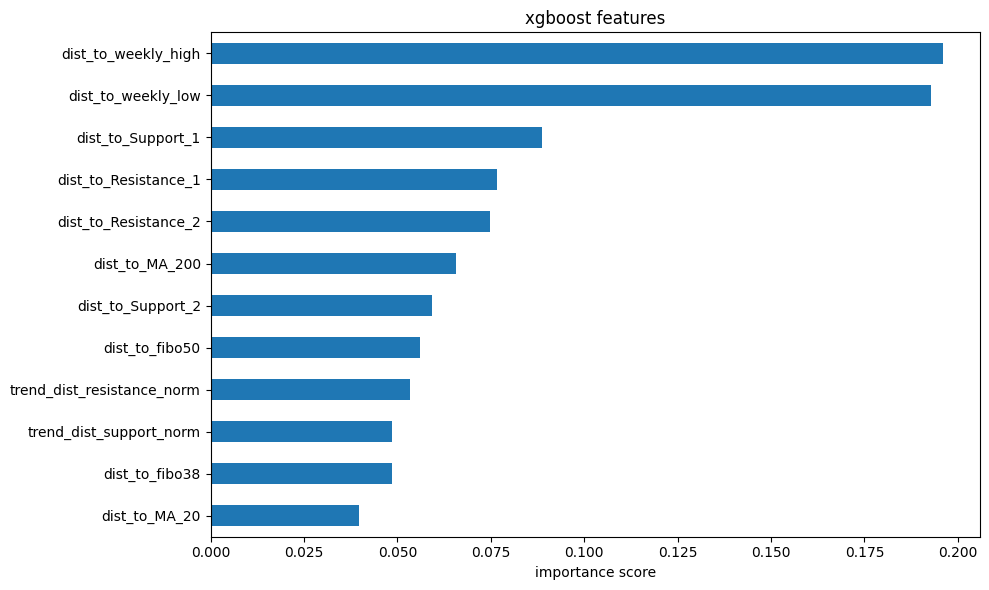

Window 1 Accuracy : 0.681
label
2    3460
0    3261
1    2285
Name: count, dtype: int64
window 1 Classification Report :
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       620
           1       0.53      0.40      0.46       363
           2       0.70      0.80      0.75       540

    accuracy                           0.68      1523
   macro avg       0.65      0.65      0.65      1523
weighted avg       0.67      0.68      0.67      1523

Results saved to walkforwards/EURUSD.ecn/14_3/2025_10_09_13_23_0.68/walk_forward_results_EURUSD.ecn.csv
Confusion matrices saved to walkforwards/EURUSD.ecn/14_3/2025_10_09_13_23_0.68/confusion_matrices_EURUSD.ecn.pkl
Detailed report saved

=== Walk-Forward Validation Summary ===
Total predictions: 1523
Overall accuracy: 0.681


In [20]:
import os
import pickle
import data_manager
import feature_generator
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def run_walk_forward_validation(symbol,timeframe,train_months,validation_months,n_windows):
    
    total_months = train_months + (validation_months * n_windows)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=total_months * 30)
    
    print(f"Downloading data from {start_date} to {end_date}")
    full_data = data_manager.get_mt5_rates(symbol, timeframe, "time_range",from_time=start_date, to_time=end_date)
    
    if full_data is None:
        return None, None
        
    features = feature_generator.MT5FeaturesManager(full_data)
    feature = features.add_all_features()
    clean_features = features.handle_missing_values('drop')

    all_predictions = []
    confusion_matrices = {}
    for window in reversed(range(n_windows)):
        print(f"\nProcessing window {window*-1 + n_windows}/{n_windows}")
        
        window_end = end_date - timedelta(days=window * validation_months * 30)
        val_start = window_end - timedelta(days=validation_months * 30)
        train_end = val_start
        train_start = train_end - timedelta(days=train_months * 30)
        
        
        
        # Split data
        full_mask = (clean_features.index >= train_start) & (clean_features.index <= window_end) 
        data = clean_features[full_mask].copy()
        y_data_mask = (clean_features.index >= val_start) & (clean_features.index <= window_end)
        y_data = clean_features[y_data_mask].copy()
        
        train_mask = (clean_features.index >= train_start) & (clean_features.index < train_end)
        test_mask = (clean_features.index >= val_start) & (clean_features.index <= window_end)
        train_data = clean_features[train_mask].copy()
        test_data = clean_features[test_mask].copy()

        print(f"Full Data len : {len(full_data)}\nsplit size : {100 - (len(test_data)/len(train_data))*100:.0f} %")
        print(f"Train : {train_start.strftime('%Y-%m-%d %H:%M:%S')} to {train_end.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Validation : {val_start.strftime('%Y-%m-%d %H:%M:%S')} to {window_end.strftime('%Y-%m-%d %H:%M:%S')}")
        
        if len(data) == 0 or len(y_data) == 0:
            print(f"Window {window*-1 + n_windows}: No data available for this period")
            continue
        
        # Prepare features and targets
        labeled = feature_generator.create_target_variable(data,50,'dynamic_max_min',1.0)
        
        top_features = [#'MA_50','EMA_12','EMA_26', 'BB_Mid','BB_Low','BB_High',
            # 'MACD', 'MACD_Signal','Volatility',
            # "MA_Cross50/100","MA_Cross100/200",
            "dist_to_weekly_high","dist_to_weekly_low", 'dist_to_Support_1','dist_to_Support_2', 'dist_to_Resistance_1','dist_to_Resistance_2',#,#'dist_to_Support_2', 'dist_to_Resistance_2',
            #'Support_1', 'Support_2', 'Resistance_1', 'Resistance_2',
            # 'adx_di_crossover',
            'dist_to_MA_200','dist_to_MA_20',
            #'Fib_382',# 'Fib_500',#'OBV',
            'dist_to_fibo38','dist_to_fibo50',
            #'trend_dist_support','trend_dist_resistance',
            'trend_dist_support_norm','trend_dist_resistance_norm'
            ]
        new_top_features = []
        X = labeled[top_features]
        Y = labeled["label"]
        
        
        X_train, y_train = X.loc[train_data.index],Y.loc[train_data.index]
        X_test, y_test = X.loc[test_data.index], Y.loc[test_data.index]
        
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Window {window*-1 + n_windows}: Not enough data after feature engineering")
            continue
        
        # Train & prediction & metrics
        print(f"Training on {len(X_train)} samples...")
        model = XGBClassifier(
            objective="multi:softmax",
            num_class=3,
            eval_metric="mlogloss",
            n_estimators=500,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(X_train,y_train)
        model.save_model('model/H1/H1_model.json')
        print(f"Predicting on {len(X_test)} validation samples...")
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        features_importance = model.feature_importances_
        features_names = X.columns
        importance = pd.Series(features_importance,features_names)
        sorted_importance = importance.sort_values(ascending=True)
        plt.figure(figsize=(10,6))
        sorted_importance.plot(kind="barh")
        plt.title("xgboost features")
        plt.xlabel("importance score")
        plt.tight_layout()
        plt.show()
        
        cm = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        cr = classification_report(y_test, y_pred, zero_division=0,digits=2)
        confusion_matrices[window] = {
            'matrix': cm,
            'accuracy': accuracy,
            'classification_report': classification_report(y_test, y_pred, zero_division=0,digits=2, output_dict=True)
        }
        print(f"Window {window*-1 + n_windows} Accuracy : {accuracy:.3f}")
        print(Y.value_counts())
        print(f"window {window*-1 + n_windows} Classification Report :\n{cr}")
        
        # Store predictions with timestamps
        window_predictions = y_data[['Close']].copy()
        window_predictions['y_true'] = y_test.values
        window_predictions['y_pred'] = y_pred
        window_predictions['y_pred_proba_0'] = y_proba[:, 0]
        window_predictions['y_pred_proba_1'] = y_proba[:, 1]
        window_predictions['y_pred_proba_2'] = y_proba[:, 2]
        window_predictions['window'] = window*-1 + n_windows
        
        all_predictions.append(window_predictions)
    
    # Combine all predictions
    if all_predictions:
        results_df = pd.concat(all_predictions)
    
    mt5.shutdown()
    return results_df, confusion_matrices, top_features
    
def save_results(result_df,top_features, results_path, cm_path, tf_path):

    if not results_df.empty:
        results_df.to_csv(results_path, index=True)
        print(f"Results saved to {results_path}")
    
    if confusion_matrices:
        with open(cm_path, 'wb') as f:
            pickle.dump(confusion_matrices, f)
        print(f"Confusion matrices saved to {cm_path}")

    if top_features:
        with open(tf_path, "w") as output:
            output.write(str(top_features))
    
        # Also save human-readable version
        cm_text = ""
        for window, metrics in confusion_matrices.items():
            cm_text += f"=== {window} ===\n"
            cm_text += f"Accuracy: {metrics['accuracy']:.2f}\n"
            cm_text += f"Confusion Matrix:\n{metrics['matrix']}\n\n"
            cm_text += "Classification Report:\n"
            cm_text += str(pd.DataFrame(metrics['classification_report']).round(2)) + "\n\n"
        
        with open(PATH+f"confusion_matrices_report_{SYMBOL}.txt", 'w') as f:
            f.write(cm_text)
        print(f"Detailed report saved")

# Example usage
if __name__ == "__main__":
    # Configuration
    SYMBOL = "EURUSD.ecn"
    TIMEFRAME = mt5.TIMEFRAME_H1
    PATH = "walkforwards/EURUSD.ecn/14_3/"
    TRAIN_MONTHS = 15  # 6 months training
    VALIDATION_MONTHS = 3  # 1 month validation
    N_WINDOWS = 1  # 5 windows

    
        # Create nested directories (creates parent directories if they don't exist)
        # os.makedirs("parent/child/grandchild", exist_ok=True)
    
    # Run walk-forward validation
    results_df, confusion_matrices, top_features = run_walk_forward_validation(symbol=SYMBOL,
        timeframe=TIMEFRAME,
        train_months=TRAIN_MONTHS,
        validation_months=VALIDATION_MONTHS,
        n_windows=N_WINDOWS)
    
    # Save results
    if results_df is not None:
        PATH = PATH+f"{datetime.now().strftime('%Y_%m_%d_%H_%M')}_{accuracy_score(results_df['y_true'], results_df['y_pred']):.2f}/"
        os.makedirs(PATH,exist_ok=True)
        save_results(results_df,top_features, results_path=PATH+f"walk_forward_results_{SYMBOL}.csv",
                      cm_path=PATH+f"confusion_matrices_{SYMBOL}.pkl",
                       tf_path=PATH+f"top_features_{SYMBOL}.txt")
        
        # Display summary
        print("\n=== Walk-Forward Validation Summary ===")
        print(f"Total predictions: {len(results_df)}")
        print(f"Overall accuracy: {accuracy_score(results_df['y_true'], results_df['y_pred']):.3f}")
    
    else:
        print("Walk-forward validation failed. Check MT5 connection and data availability.")

In [14]:
importlib.reload(feature_generator)

<module 'feature_generator' from 'G:\\extracted\\ML\\GoldUsd\\trading_bot\\feature_generator.py'>

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_confusion_matrices(pkl_file_path):
    """
    Load and analyze the confusion matrices from a PKL file for multi-class classification
    
    Parameters:
    pkl_file_path (str): Path to the PKL file
    """
    
    # Load the confusion matrices
    with open(pkl_file_path, 'rb') as f:
        confusion_matrices = pickle.load(f)
    
    # Create a summary DataFrame
    summary_data = []
    for window, metrics in confusion_matrices.items():
        cm = metrics['matrix']
        
        # Calculate multi-class metrics
        accuracy = metrics['accuracy']
        
        # Calculate precision, recall, and F1 for each class
        class_metrics = {}
        for i in range(cm.shape[0]):  # For each class
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            tn = cm.sum() - (tp + fp + fn)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            class_metrics[f'Class_{i}_Precision'] = precision
            class_metrics[f'Class_{i}_Recall'] = recall
            class_metrics[f'Class_{i}_F1'] = f1_score
            class_metrics[f'Class_{i}_TP'] = tp
            class_metrics[f'Class_{i}_FP'] = fp
            class_metrics[f'Class_{i}_TN'] = tn
            class_metrics[f'Class_{i}_FN'] = fn
        
        # Calculate macro-averaged metrics
        precisions = [class_metrics[f'Class_{i}_Precision'] for i in range(cm.shape[0])]
        recalls = [class_metrics[f'Class_{i}_Recall'] for i in range(cm.shape[0])]
        f1_scores = [class_metrics[f'Class_{i}_F1'] for i in range(cm.shape[0])]
        
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1_scores)
        
        window_data = {
            'Window': window,
            'Accuracy': accuracy,
            'Macro_Precision': macro_precision,
            'Macro_Recall': macro_recall,
            'Macro_F1': macro_f1,
        }
        
        # Add class-specific metrics
        window_data.update(class_metrics)
        summary_data.append(window_data)
    
    summary_df = pd.DataFrame(summary_data)
    
    return summary_df, confusion_matrices

def plot_performance_metrics(summary_df):
    """
    Plot performance metrics over windows for multi-class classification
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Metrics Across Windows (Multi-Class)', fontsize=16)
    
    # Accuracy
    axes[0, 0].plot(summary_df['Window'], summary_df['Accuracy'], marker='o', linewidth=2)
    axes[0, 0].set_title('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(True)
    
    # Macro Precision and Recall
    axes[0, 1].plot(summary_df['Window'], summary_df['Macro_Precision'], marker='o', label='Macro Precision', linewidth=2)
    axes[0, 1].plot(summary_df['Window'], summary_df['Macro_Recall'], marker='s', label='Macro Recall', linewidth=2)
    axes[0, 1].set_title('Macro Precision and Recall')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Macro F1-Score
    axes[1, 0].plot(summary_df['Window'], summary_df['Macro_F1'], marker='o', color='green', linewidth=2)
    axes[1, 0].set_title('Macro F1-Score')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True)
    
    # Class-specific F1 Scores
    class_colors = ['red', 'blue', 'green']
    for i in range(3):  # Assuming 3 classes
        if f'Class_{i}_F1' in summary_df.columns:
            axes[1, 1].plot(summary_df['Window'], summary_df[f'Class_{i}_F1'], 
                           marker='o', color=class_colors[i], label=f'Class {i} F1', linewidth=2)
    axes[1, 1].set_title('Class-specific F1 Scores')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('performance_metrics_multi_class.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrices_heatmap(confusion_matrices):
    """
    Create heatmaps of confusion matrices for each window for multi-class
    """
    n_windows = len(confusion_matrices)
    n_cols = min(3, n_windows)
    n_rows = (n_windows + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(-1, n_cols)
    
    fig.suptitle('Confusion Matrices Heatmaps (Multi-Class)', fontsize=16)
    
    class_names = ['Short (0)', 'Range (1)', 'Long (2)']
    
    for idx, (window, metrics) in enumerate(confusion_matrices.items()):
        row = idx // n_cols
        col = idx % n_cols
        
        cm = metrics['matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names[:cm.shape[0]],
                   yticklabels=class_names[:cm.shape[0]],
                   ax=axes[row, col])
        axes[row, col].set_title(f'{window} (Accuracy: {metrics["accuracy"]:.3f})')
    
    # Remove empty subplots
    for idx in range(n_windows, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_heatmap_multi_class.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_performance(summary_df):
    """
    Plot performance metrics for each class separately
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Class-specific Performance Metrics', fontsize=16)
    
    class_names = ['Short (0)', 'Range (1)', 'Long (2)']
    class_colors = ['red', 'blue', 'green']
    
    for i in range(3):
        # Precision
        axes[i, 0].plot(summary_df['Window'], summary_df[f'Class_{i}_Precision'], 
                       marker='o', color=class_colors[i], linewidth=2)
        axes[i, 0].set_title(f'{class_names[i]} - Precision')
        axes[i, 0].set_ylim(0, 1)
        axes[i, 0].grid(True)
        
        # Recall
        axes[i, 1].plot(summary_df['Window'], summary_df[f'Class_{i}_Recall'], 
                       marker='s', color=class_colors[i], linewidth=2)
        axes[i, 1].set_title(f'{class_names[i]} - Recall')
        axes[i, 1].set_ylim(0, 1)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('class_performance_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

def calculate_consistency_metrics(summary_df):
    """
    Calculate consistency metrics across windows for multi-class
    """
    consistency_metrics = {
        'Average Accuracy': summary_df['Accuracy'].mean(),
        'Accuracy Std': summary_df['Accuracy'].std(),
        'Average Macro Precision': summary_df['Macro_Precision'].mean(),
        'Average Macro Recall': summary_df['Macro_Recall'].mean(),
        'Average Macro F1': summary_df['Macro_F1'].mean(),
        'Win Rate': (summary_df['Accuracy'] > 0.33).mean(),  # Better than random for 3 classes
    }
    
    # Add class-specific consistency metrics
    for i in range(3):
        consistency_metrics[f'Class_{i}_Avg_Precision'] = summary_df[f'Class_{i}_Precision'].mean()
        consistency_metrics[f'Class_{i}_Avg_Recall'] = summary_df[f'Class_{i}_Recall'].mean()
        consistency_metrics[f'Class_{i}_Avg_F1'] = summary_df[f'Class_{i}_F1'].mean()
    
    return consistency_metrics

def generate_performance_report(summary_df, confusion_matrices, output_file='performance_report_multi_class.txt'):
    """
    Generate a comprehensive performance report for multi-class classification
    """
    consistency_metrics = calculate_consistency_metrics(summary_df)
    
    with open(output_file, 'w') as f:
        f.write("MULTI-CLASS WALK-FORWARD VALIDATION PERFORMANCE REPORT\n")
        f.write("======================================================\n\n")
        f.write(f"Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("Class mapping: 0=Short, 1=Range, 2=Long\n\n")
        
        f.write("SUMMARY METRICS ACROSS ALL WINDOWS\n")
        f.write("---------------------------------\n")
        for metric, value in consistency_metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        
        f.write("\nDETAILED PERFORMANCE BY WINDOW\n")
        f.write("-----------------------------\n")
        for _, row in summary_df.iterrows():
            f.write(f"\n{row['Window']}:\n")
            f.write(f"  Accuracy: {row['Accuracy']:.4f}\n")
            f.write(f"  Macro Precision: {row['Macro_Precision']:.4f}\n")
            f.write(f"  Macro Recall: {row['Macro_Recall']:.4f}\n")
            f.write(f"  Macro F1: {row['Macro_F1']:.4f}\n")
            
            for i in range(3):
                f.write(f"  Class {i} ({'Short' if i==0 else 'Range' if i==1 else 'Long'}):\n")
                f.write(f"    Precision: {row[f'Class_{i}_Precision']:.4f}\n")
                f.write(f"    Recall: {row[f'Class_{i}_Recall']:.4f}\n")
                f.write(f"    F1: {row[f'Class_{i}_F1']:.4f}\n")
                f.write(f"    TP: {row[f'Class_{i}_TP']}, FP: {row[f'Class_{i}_FP']}, TN: {row[f'Class_{i}_TN']}, FN: {row[f'Class_{i}_FN']}\n")
        
        f.write("\nCONFUSION MATRICES\n")
        f.write("------------------\n")
        for window, metrics in confusion_matrices.items():
            f.write(f"\n{window}:\n")
            f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
            f.write("Confusion Matrix:\n")
            f.write(f"{metrics['matrix']}\n")
    
    print(f"Performance report saved to {output_file}")

# Example usage
if __name__ == "__main__":
    # Analyze the PKL file
    summary_df, confusion_matrices = analyze_confusion_matrices("walkforwards/XAUUSD/6_1/confusion_matrices_XAUUSD_2025_09_12.pkl")
    
    # Display summary
    print("Performance Summary:")
    print("===================")
    print(summary_df[['Window', 'Accuracy', 'Macro_Precision', 'Macro_Recall', 'Macro_F1']])
    
    # Calculate and display consistency metrics
    consistency_metrics = calculate_consistency_metrics(summary_df)
    print("\nConsistency Metrics:")
    print("===================")
    for metric, value in consistency_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Generate visualizations
    plot_performance_metrics(summary_df)
    plot_confusion_matrices_heatmap(confusion_matrices)
    plot_class_performance(summary_df)
    
    # Generate a detailed report
    generate_performance_report(summary_df, confusion_matrices)
    
    # Save the summary DataFrame to CSV for further analysis
    summary_df.to_csv('performance_summary_multi_class.csv', index=False)
    print("\nPerformance summary saved to performance_summary_multi_class.csv")

Performance Summary:
   Window  Accuracy  Macro_Precision  Macro_Recall  Macro_F1
0       0  0.281437         0.286609      0.305942  0.266200
1       4  0.482402         0.575724      0.467186  0.432908
2       3  0.386037         0.422260      0.425280  0.378251
3       2  0.419214         0.429710      0.425044  0.422241
4       1  0.498024         0.531115      0.507716  0.477172

Consistency Metrics:
Average Accuracy: 0.4134
Accuracy Std: 0.0868
Average Macro Precision: 0.4491
Average Macro Recall: 0.4262
Average Macro F1: 0.3954
Win Rate: 0.8000
Class_0_Avg_Precision: 0.4042
Class_0_Avg_Recall: 0.6692
Class_0_Avg_F1: 0.4878
Class_1_Avg_Precision: 0.3695
Class_1_Avg_Recall: 0.2956
Class_1_Avg_F1: 0.3198
Class_2_Avg_Precision: 0.5735
Class_2_Avg_Recall: 0.3140
Class_2_Avg_F1: 0.3785


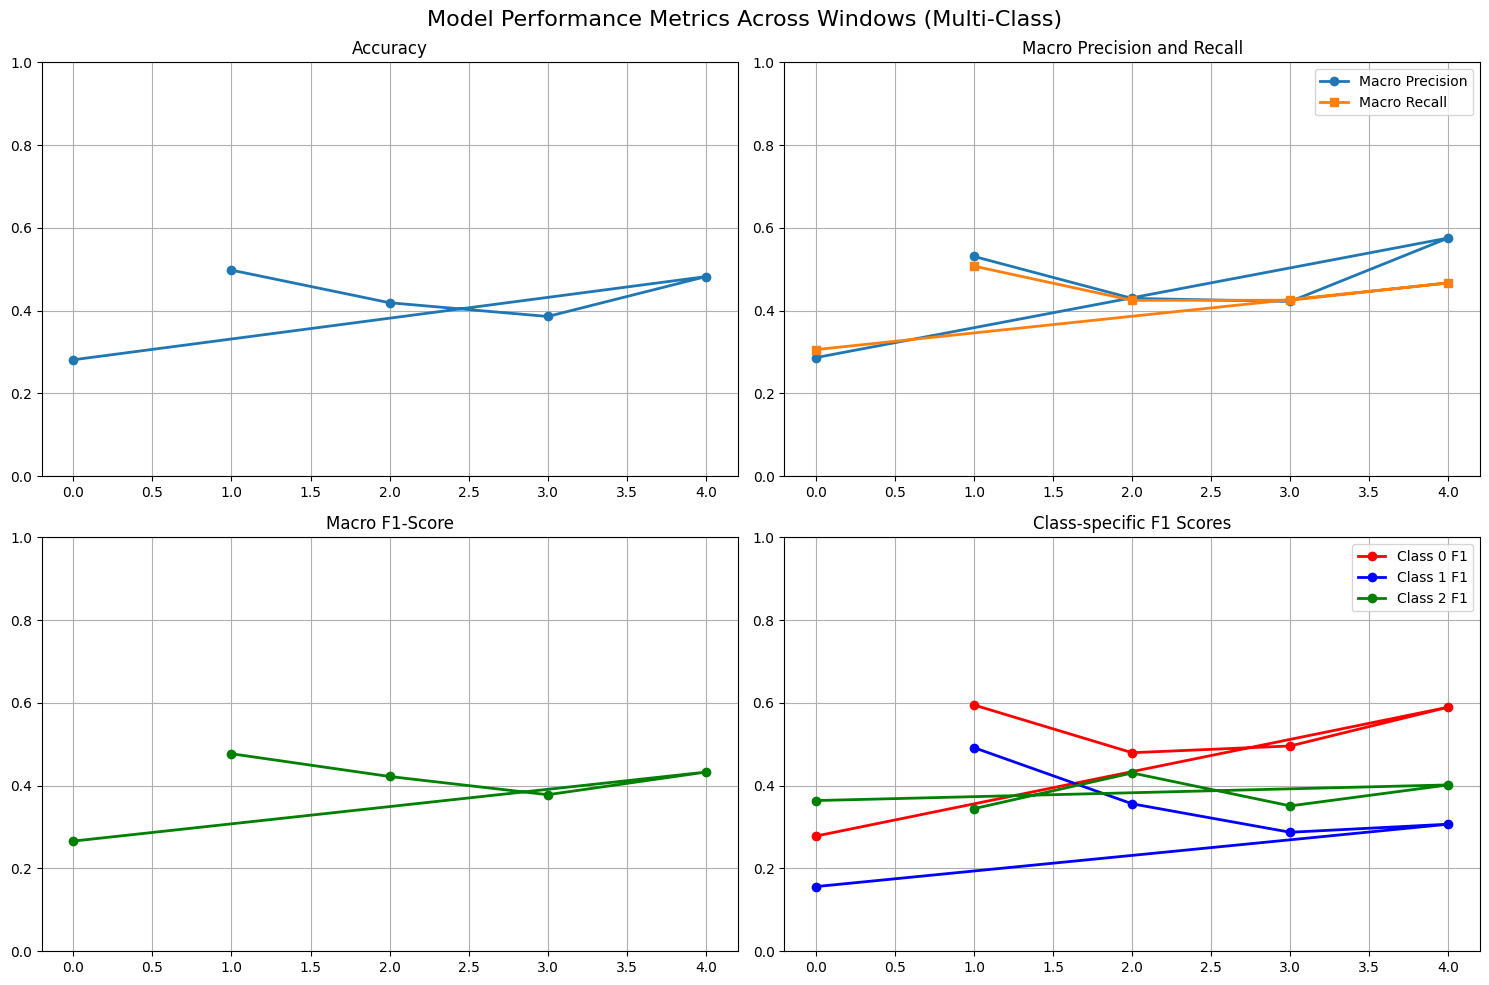

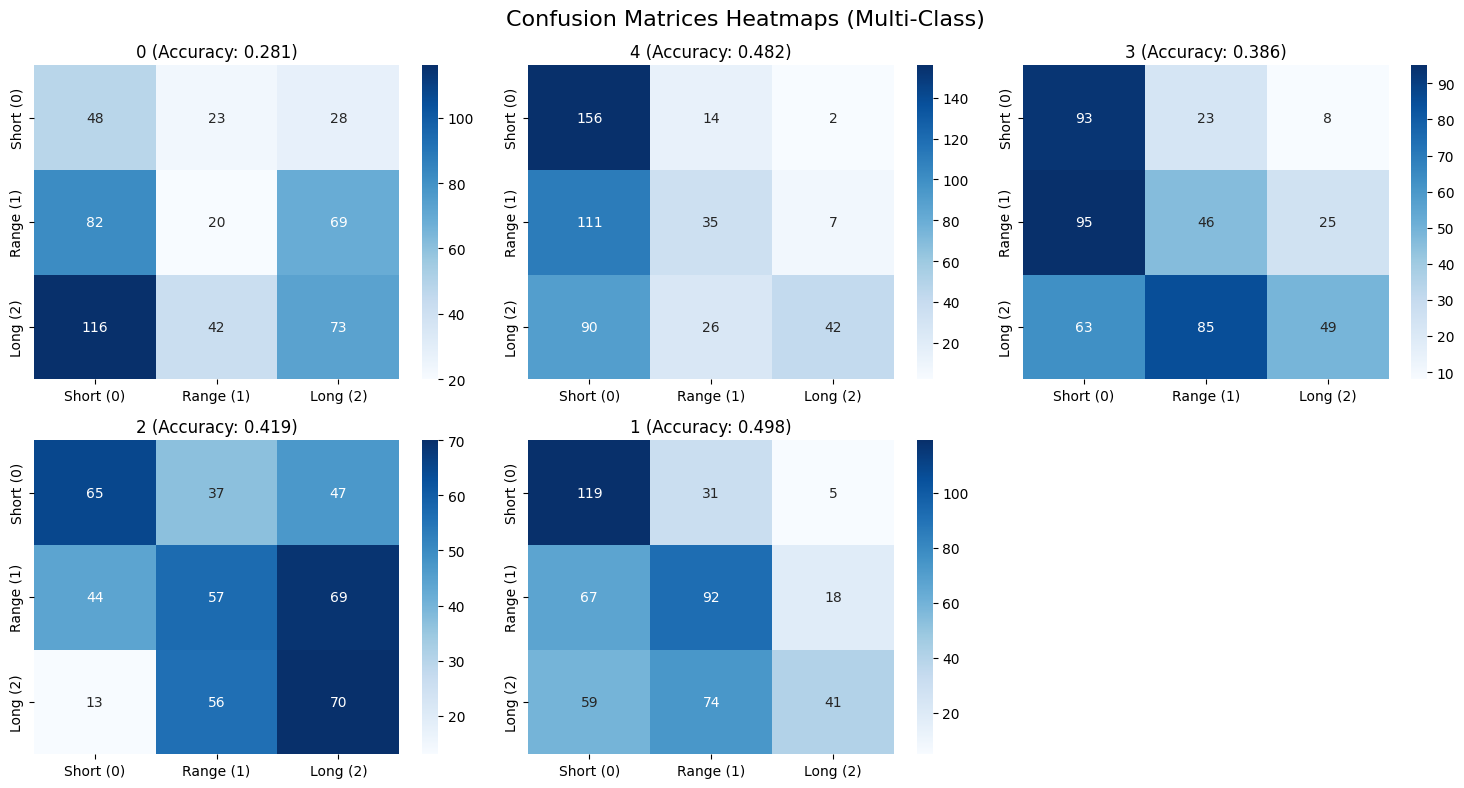

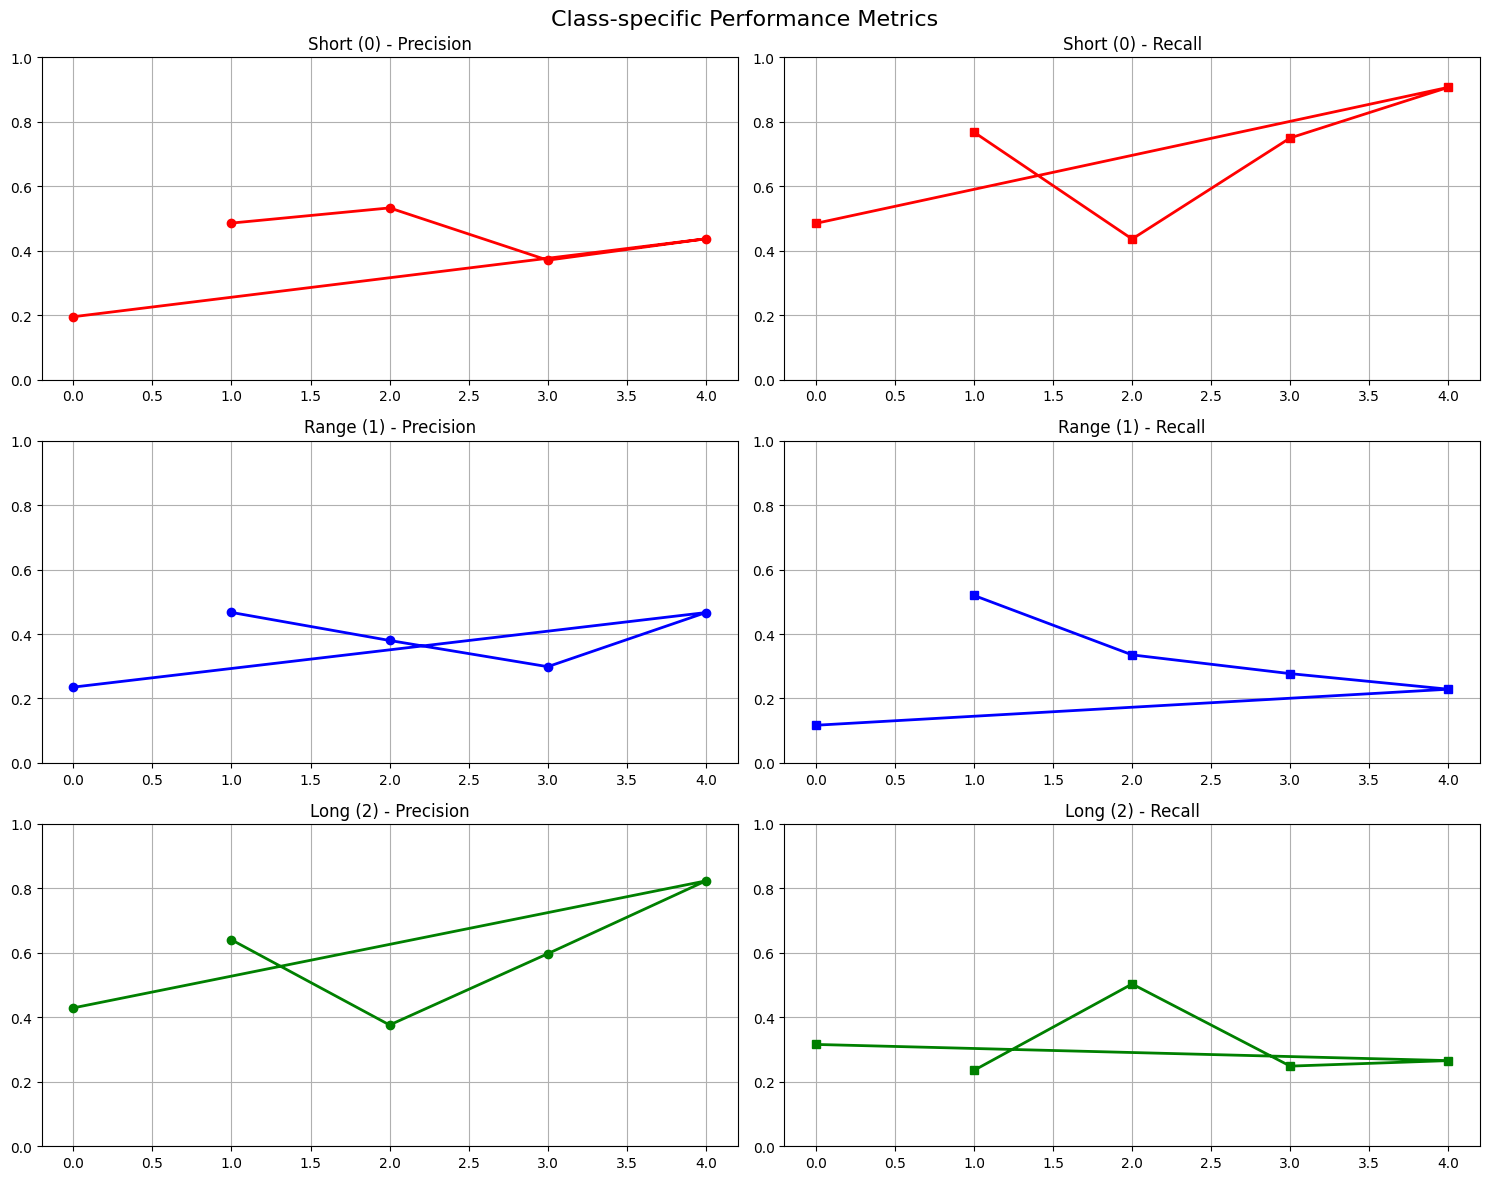

Performance report saved to performance_report_multi_class.txt

Performance summary saved to performance_summary_multi_class.csv


In [12]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
def analyze_confusion_matrices(pkl_file_path):
    """
    Load and analyze the confusion matrices from a PKL file for multi-class classification
    
    Parameters:
    pkl_file_path (str): Path to the PKL file
    """
    
    # Load the confusion matrices
    with open(pkl_file_path, 'rb') as f:
        confusion_matrices = pickle.load(f)
    
    # Sort windows in correct order (window_1, window_2, ...)
    sorted_windows = sorted(confusion_matrices.keys(), 
                           key=lambda x: int(x.split('_')[1]) if x.split('_')[0] == 'window' else 0)
    
    # Create a summary DataFrame
    summary_data = []
    for window in sorted_windows:
        metrics = confusion_matrices[window]
        cm = metrics['matrix']
        
        # Calculate multi-class metrics
        accuracy = metrics['accuracy']
        
        # Calculate precision, recall, and F1 for each class
        class_metrics = {}
        for i in range(cm.shape[0]):  # For each class
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            tn = cm.sum() - (tp + fp + fn)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            class_metrics[f'Class_{i}_Precision'] = precision
            class_metrics[f'Class_{i}_Recall'] = recall
            class_metrics[f'Class_{i}_F1'] = f1_score
            class_metrics[f'Class_{i}_TP'] = tp
            class_metrics[f'Class_{i}_FP'] = fp
            class_metrics[f'Class_{i}_TN'] = tn
            class_metrics[f'Class_{i}_FN'] = fn
        
        # Calculate macro-averaged metrics
        precisions = [class_metrics[f'Class_{i}_Precision'] for i in range(cm.shape[0])]
        recalls = [class_metrics[f'Class_{i}_Recall'] for i in range(cm.shape[0])]
        f1_scores = [class_metrics[f'Class_{i}_F1'] for i in range(cm.shape[0])]
        
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1_scores)
        
        window_data = {
            'Window': window,
            'Window_Number': int(window.split('_')[1]),  # Extract window number
            'Accuracy': accuracy,
            'Macro_Precision': macro_precision,
            'Macro_Recall': macro_recall,
            'Macro_F1': macro_f1,
        }
        
        # Add class-specific metrics
        window_data.update(class_metrics)
        summary_data.append(window_data)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Sort by window number to ensure correct order
    summary_df = summary_df.sort_values('Window_Number').reset_index(drop=True)
    
    return summary_df, confusion_matrices

In [7]:
def generate_performance_report(summary_df, confusion_matrices, output_file='performance_report_multi_class.txt'):
    """
    Generate a comprehensive performance report for multi-class classification
    """
    consistency_metrics = calculate_consistency_metrics(summary_df)
    
    # Sort confusion matrices by window number
    sorted_windows = sorted(confusion_matrices.keys(), 
                           key=lambda x: int(x.split('_')[1]) if x.split('_')[0] == 'window' else 0)
    
    with open(output_file, 'w') as f:
        f.write("MULTI-CLASS WALK-FORWARD VALIDATION PERFORMANCE REPORT\n")
        f.write("======================================================\n\n")
        f.write(f"Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("Class mapping: 0=Short, 1=Range, 2=Long\n\n")
        
        f.write("SUMMARY METRICS ACROSS ALL WINDOWS\n")
        f.write("---------------------------------\n")
        for metric, value in consistency_metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        
        f.write("\nDETAILED PERFORMANCE BY WINDOW\n")
        f.write("-----------------------------\n")
        for _, row in summary_df.iterrows():
            f.write(f"\nWindow {row['Window_Number']}:\n")
            f.write(f"  Accuracy: {row['Accuracy']:.4f}\n")
            f.write(f"  Macro Precision: {row['Macro_Precision']:.4f}\n")
            f.write(f"  Macro Recall: {row['Macro_Recall']:.4f}\n")
            f.write(f"  Macro F1: {row['Macro_F1']:.4f}\n")
            
            for i in range(3):
                f.write(f"  Class {i} ({'Short' if i==0 else 'Range' if i==1 else 'Long'}):\n")
                f.write(f"    Precision: {row[f'Class_{i}_Precision']:.4f}\n")
                f.write(f"    Recall: {row[f'Class_{i}_Recall']:.4f}\n")
                f.write(f"    F1: {row[f'Class_{i}_F1']:.4f}\n")
                f.write(f"    TP: {row[f'Class_{i}_TP']}, FP: {row[f'Class_{i}_FP']}, TN: {row[f'Class_{i}_TN']}, FN: {row[f'Class_{i}_FN']}\n")
        
        f.write("\nCONFUSION MATRICES\n")
        f.write("------------------\n")
        for window in sorted_windows:
            metrics = confusion_matrices[window]
            f.write(f"\n{window}:\n")
            f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
            f.write("Confusion Matrix:\n")
            f.write(f"{metrics['matrix']}\n")
    
    print(f"Performance report saved to {output_file}")
    

In [8]:
def plot_performance_metrics(summary_df):
    """
    Plot performance metrics over windows for multi-class classification
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Metrics Across Windows (Multi-Class)', fontsize=16)
    
    # Use Window_Number instead of Window for proper ordering
    # Accuracy
    axes[0, 0].plot(summary_df['Window_Number'], summary_df['Accuracy'], marker='o', linewidth=2)
    axes[0, 0].set_title('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(True)
    
    # Macro Precision and Recall
    axes[0, 1].plot(summary_df['Window_Number'], summary_df['Macro_Precision'], marker='o', label='Macro Precision', linewidth=2)
    axes[0, 1].plot(summary_df['Window_Number'], summary_df['Macro_Recall'], marker='s', label='Macro Recall', linewidth=2)
    axes[0, 1].set_title('Macro Precision and Recall')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # ... rest of the function remains the same

In [9]:
def plot_confusion_matrices_heatmap(confusion_matrices):
    """
    Create heatmaps of confusion matrices for each window for multi-class
    """
    # Sort windows in correct order
    sorted_windows = sorted(confusion_matrices.keys(), 
                           key=lambda x: int(x.split('_')[1]) if x.split('_')[0] == 'window' else 0)
    
    n_windows = len(sorted_windows)
    n_cols = min(3, n_windows)
    n_rows = (n_windows + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(-1, n_cols)
    
    fig.suptitle('Confusion Matrices Heatmaps (Multi-Class)', fontsize=16)
    
    class_names = ['Short (0)', 'Range (1)', 'Long (2)']
    
    for idx, window in enumerate(sorted_windows):
        row = idx // n_cols
        col = idx % n_cols
        
        metrics = confusion_matrices[window]
        cm = metrics['matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names[:cm.shape[0]],
                   yticklabels=class_names[:cm.shape[0]],
                   ax=axes[row, col])
        axes[row, col].set_title(f'{window} (Accuracy: {metrics["accuracy"]:.3f})')
    
    # Remove empty subplots
    for idx in range(n_windows, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_heatmap_multi_class.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
def generate_performance_report(summary_df, confusion_matrices, output_file='performance_report_multi_class.txt'):
    """
    Generate a comprehensive performance report for multi-class classification
    """
    consistency_metrics = calculate_consistency_metrics(summary_df)
    
    # Sort confusion matrices by window number
    sorted_windows = sorted(confusion_matrices.keys(), 
                           key=lambda x: int(x.split('_')[1]) if x.split('_')[0] == 'window' else 0)
    
    with open(output_file, 'w') as f:
        f.write("MULTI-CLASS WALK-FORWARD VALIDATION PERFORMANCE REPORT\n")
        f.write("======================================================\n\n")
        f.write(f"Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("Class mapping: 0=Short, 1=Range, 2=Long\n\n")
        
        f.write("SUMMARY METRICS ACROSS ALL WINDOWS\n")
        f.write("---------------------------------\n")
        for metric, value in consistency_metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        
        f.write("\nDETAILED PERFORMANCE BY WINDOW\n")
        f.write("-----------------------------\n")
        for _, row in summary_df.iterrows():
            f.write(f"\nWindow {row['Window_Number']}:\n")
            f.write(f"  Accuracy: {row['Accuracy']:.4f}\n")
            f.write(f"  Macro Precision: {row['Macro_Precision']:.4f}\n")
            f.write(f"  Macro Recall: {row['Macro_Recall']:.4f}\n")
            f.write(f"  Macro F1: {row['Macro_F1']:.4f}\n")
            
            for i in range(3):
                f.write(f"  Class {i} ({'Short' if i==0 else 'Range' if i==1 else 'Long'}):\n")
                f.write(f"    Precision: {row[f'Class_{i}_Precision']:.4f}\n")
                f.write(f"    Recall: {row[f'Class_{i}_Recall']:.4f}\n")
                f.write(f"    F1: {row[f'Class_{i}_F1']:.4f}\n")
                f.write(f"    TP: {row[f'Class_{i}_TP']}, FP: {row[f'Class_{i}_FP']}, TN: {row[f'Class_{i}_TN']}, FN: {row[f'Class_{i}_FN']}\n")
        
        f.write("\nCONFUSION MATRICES\n")
        f.write("------------------\n")
        for window in sorted_windows:
            metrics = confusion_matrices[window]
            f.write(f"\n{window}:\n")
            f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
            f.write("Confusion Matrix:\n")
            f.write(f"{metrics['matrix']}\n")
    
    print(f"Performance report saved to {output_file}")

In [13]:
# Example usage
if __name__ == "__main__":
    # Analyze the PKL file
    summary_df, confusion_matrices = analyze_confusion_matrices("walkforwards/XAUUSD/6_1/confusion_matrices_XAUUSD_2025_09_12.pkl")
    
    # Display summary
    print("Performance Summary:")
    print("===================")
    print(summary_df[['Window', 'Accuracy', 'Macro_Precision', 'Macro_Recall', 'Macro_F1']])
    
    # Calculate and display consistency metrics
    consistency_metrics = calculate_consistency_metrics(summary_df)
    print("\nConsistency Metrics:")
    print("===================")
    for metric, value in consistency_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Generate visualizations
    plot_performance_metrics(summary_df)
    plot_confusion_matrices_heatmap(confusion_matrices)
    plot_class_performance(summary_df)
    
    # Generate a detailed report
    generate_performance_report(summary_df, confusion_matrices)
    
    # Save the summary DataFrame to CSV for further analysis
    summary_df.to_csv('performance_summary_multi_class.csv', index=False)
    print("\nPerformance summary saved to performance_summary_multi_class.csv")

AttributeError: 'int' object has no attribute 'split'

In [29]:
closed = mt5.history_deals_get((2025,8,8), datetime.now()+timedelta(hours=3))  # since_ts

In [30]:
print(closed)

None
